# Starbucks Capstone Challenge

## 1. Business Understanding

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [92]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer

plt.style.use('ggplot')

## 2. Data Understanding

### 2.1 Collect Data

In [93]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 2.2 Describe/Explore Data

In [94]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [95]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [96]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [97]:
# Check for NaN's

portfolio.isnull().values.any()

False

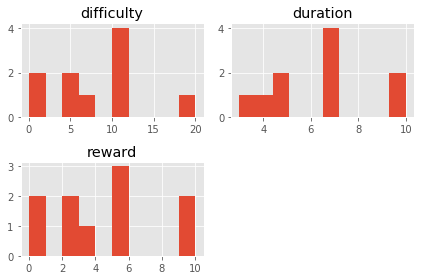

In [98]:
portfolio.hist()
plt.tight_layout();

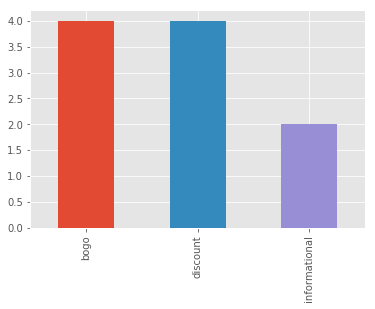

In [99]:
# Distribution of 'offer_type'
portfolio['offer_type'].value_counts().plot(kind='bar');

#### To Clean: `portfolio`

- **channel** 
    - create individual columns for variables
- **duration**
    - convert days to hours

In [100]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [101]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [102]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


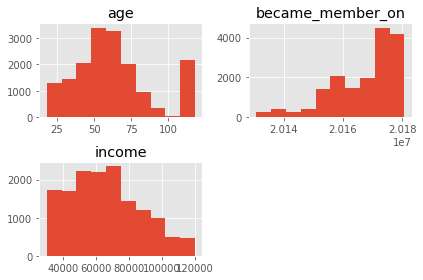

In [103]:
profile.hist()
plt.tight_layout();

In [104]:
# Check for NaN's

profile.isnull().values.any()

True

In [105]:
# Review rows that contain NaN value

profile_nans = profile[profile.isnull().values == True]
profile_nans.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [106]:
profile_nans.describe()

,age,became_member_on,income
count,4350.0,4.350000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.008989e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


All rows that contain NaN values are missing data for 'age' (all ages are listed as 118, which is highly improbable), 'gender', and 'income'. These rows will not provide us with relevent data for analysis, so these rows should be removed.

#### To Clean: `profile`

- **became_member_on** 
    - change to datetime type
- **id**
    - change title to "customer_id"
- remove rows that contain NaN values

In [107]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [108]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [109]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


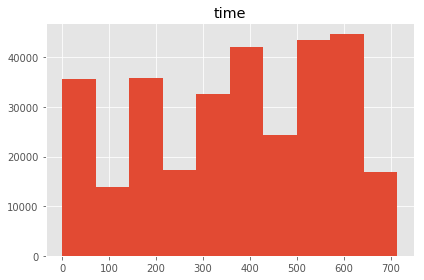

In [110]:
transcript.hist()
plt.tight_layout();

#### To Clean: `transcript`

- **person**
    - change title to "customer_id"

## 3. Data Preperation

### 3.1 Clean Data

#### 3.1.1 Portfolio

In [111]:
# Create copies of loaded data sets
portfolio_new = portfolio.copy()
profile_new = profile.copy()
transcript_new = transcript.copy()

In [112]:
# Create dummies for each channel in lists within the 'channels' column
# then remove 'channels' column.
mlb = MultiLabelBinarizer()

portfolio_new = pd.concat([portfolio_new, 
                          pd.DataFrame(mlb.fit_transform(portfolio_new['channels']),columns=mlb.classes_, index=portfolio_new.index)],
                          axis=1, sort=False
                         )

portfolio_new = portfolio_new.drop('channels', axis=1)

portfolio_new

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [113]:
portfolio_new.rename(columns={'id': 'offer id'}, inplace=True)

In [114]:
portfolio_new['duration'] = portfolio_new['duration'] * 24

In [115]:
portfolio_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
difficulty    10 non-null int64
duration      10 non-null int64
offer id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
email         10 non-null int32
mobile        10 non-null int32
social        10 non-null int32
web           10 non-null int32
dtypes: int32(4), int64(3), object(2)
memory usage: 640.0+ bytes


#### 3.1.2 Profile

- **became_member_on** 
    - change to datetime type
- **id**
    - change title to "customer_id"
- remove rows that contain NaN values

In [116]:
# Change 'became_member_on' field to datetime data type

profile_new['became_member_on'] = profile_new['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [117]:
# Change 'id' field name to 'customer_id' for consistency

profile_new.rename(columns={'id': 'customer_id'}, inplace=True)

In [118]:
# Remove rows with NaN values

profile_new = profile_new.dropna()

In [119]:
profile_new.head()

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [120]:
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


#### 3.1.3 Transcript

In [121]:
transcript_new.rename(columns={'person':'customer_id'}, inplace=True)

In [122]:
# Sort transcript_new by 'person' and 'time'

transcript_new = transcript_new.set_index(['customer_id', 'time']).sort_values(by=['customer_id', 'time']).reset_index()
transcript_new.head()

,customer_id,time,event,value
0,0009655768c64bdeb2e877511632db8f,168,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
2,0009655768c64bdeb2e877511632db8f,228,transaction,{'amount': 22.16}
3,0009655768c64bdeb2e877511632db8f,336,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


In [123]:
# Break out the various dictionary keys within 'value' field as their own columns
# then return the respective values for each 'time' value

transcript_new = pd.concat([transcript_new.drop(['value'], axis=1), transcript_new['value'].apply(pd.Series)], axis=1)
transcript_new.head(10)

,customer_id,time,event,offer id,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,414,offer completed,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [124]:
# Fill NaN values with 0 for 'amount' and 'reward' fields

transcript_new['amount'] = transcript_new['amount'].fillna(0)
transcript_new['reward'] = transcript_new['reward'].fillna(0)

In [125]:
# Move the non NaN values in 'offer_id' to 'offer id'
# then remove 'offer_id' column

transcript_new['offer id'] = transcript_new['offer id'].fillna(transcript_new['offer_id'])
transcript_new = transcript_new.drop(columns='offer_id', axis=1)
transcript_new.head(10)

,customer_id,time,event,offer id,amount,reward
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0


In [126]:
print(transcript.shape)
print(transcript_new.shape)

(306534, 4)
(306534, 6)


### 3.2 Construct Data

Now that the `portfolio`, `profile`, and `transcript`tables have been cleaned, it's time to contruct a data table to use for analysis and modeling.



In [127]:
# Merge 'portfolio_new' fields into 'transcript_new' table

transcript_new = transcript_new.merge(portfolio_new, on='offer id', how='left')
transcript_new.head()

,customer_id,time,event,offer id,amount,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0


In [128]:
# Rename columns

transcript_new.rename(columns={'reward_x': 'amt_rewarded',
                               'reward_y': 'offer_reward',
                               'email': 'offer_email',
                               'mobile': 'offer_mobile',
                               'social': 'offer_social',
                               'web': 'offer_web'}, inplace=True)

In [129]:
# Merge 'profile_new' fields into 'transcript_new' table

transcript_new = transcript_new.merge(profile_new, on='customer_id', how='left')

In [130]:
transcript_new.head(10)

,customer_id,time,event,offer id,amount,amt_rewarded,difficulty,duration,offer_type,offer_reward,offer_email,offer_mobile,offer_social,offer_web,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0


In [131]:
transcript_new.shape

(306534, 18)

In [132]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
customer_id         306534 non-null object
time                306534 non-null int64
event               306534 non-null object
offer id            167581 non-null object
amount              306534 non-null float64
amt_rewarded        306534 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
offer_reward        167581 non-null float64
offer_email         167581 non-null float64
offer_mobile        167581 non-null float64
offer_social        167581 non-null float64
offer_web           167581 non-null float64
age                 272762 non-null float64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(5)
memory usage: 44.4+ MB


In [133]:
transcript_new[transcript_new['offer id'].isnull()].head()

,customer_id,time,event,offer id,amount,amt_rewarded,difficulty,duration,offer_type,offer_reward,offer_email,offer_mobile,offer_social,offer_web,age,became_member_on,gender,income
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
10,0009655768c64bdeb2e877511632db8f,528,transaction,NaN,14.11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
13,0009655768c64bdeb2e877511632db8f,552,transaction,NaN,13.56,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
15,0009655768c64bdeb2e877511632db8f,576,transaction,NaN,10.27,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0


In [134]:
# Calculate number of NaN values

transcript_new[transcript_new['offer id'].isnull()]['event'].value_counts(dropna=False)

transaction    138953
Name: event, dtype: int64

In [135]:
# Number of unique customers

transcript_new['customer_id'].nunique()

17000

In [136]:
# Create list of customers with no profile
# then remove these customers from the analysis

missing_customers = []
for cust in list(set(transcript_new['customer_id'])):
    if cust not in list(set(profile_new['customer_id'])):
        missing_customers.append(cust)
            
len(missing_customers)

2175

In [137]:
# Keep only 'customer_id' items that have a profile

transcript_new = transcript_new[~transcript_new['customer_id'].isin(missing_customers)]
transcript_new.head(10)

,customer_id,time,event,offer id,amount,amt_rewarded,difficulty,duration,offer_type,offer_reward,offer_email,offer_mobile,offer_social,offer_web,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0


In [138]:
len(set(transcript_new['customer_id']))

14825

In [139]:
# Fill NaN's with 0 (for int values) or X (for str values)

col_list = ['difficulty', 'duration', 'offer_type', 'offer_reward', 'offer_email', 
            'offer_mobile', 'offer_social', 'offer_web']

def fill_nan(df, cols):
    
    for col in cols:
        if df[col].dtype == 'O':
            df[col].fillna('X', inplace=True)
        else:
            df[col].fillna(0, inplace=True)
    return df

In [140]:
fill_nan(transcript_new, col_list)

,customer_id,time,event,offer id,amount,amt_rewarded,difficulty,duration,offer_type,offer_reward,offer_email,offer_mobile,offer_social,offer_web,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,0.0,0.0,X,0.0,0.0,0.0,0.0,0.0,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0,0.0,0.0,X,0.0,0.0,0.0,0.0,0.0,33.0,2017-04-21,M,72000.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33.0,2017-04-21,M,72000.0


In [141]:
# Create age_group bins
# then drop 'age' column

bins = pd.IntervalIndex.from_tuples([(17, 24), (24, 35), (35, 50), (50, 75), (75, 110)])
transcript_new['age_group'] = pd.cut(transcript_new['age'], bins=bins)
transcript_new = transcript_new.drop('age', axis=1)

In [142]:
# Create income_group bins
# then drop 'income' columns

transcript_new['income_group'] = pd.cut(transcript_new['income'], bins=5)
transcript_new = transcript_new.drop('income', axis=1)

In [143]:
def transcript_event_count_grouped(df, groupby):
    '''
    Groups Starbucks transaction data by user specified field(s) and returns the count of each 'event' type along with the
    total dollar amount of transactions.
    Also returns the ratio of...
        1. offers viewed / offers and recieved
        2. offers completed / offers and recieved
    
    Inputs: df [dataframe]
            groupby [str or list] - fields to group data by
            
    Output: event_count
    '''
    
    event_count = df.groupby(groupby).agg({'event': np.count_nonzero,
                                           'amount': np.sum}).unstack()
    event_count = event_count.drop([('event', 'transaction'),
                                    ('amount', 'offer viewed'),
                                    ('amount', 'offer received'),
                                    ('amount', 'offer completed')], axis=1)
    event_count['amount', 'received_viewed_ratio'] = event_count['event']['offer viewed'] / event_count['event']['offer received']
    event_count['amount', 'received_completed_ratio'] = event_count['event']['offer completed'] / event_count['event']['offer received']
    event_count.columns = event_count.columns.droplevel()
    
    return event_count

In [144]:
event_count_by_gender = transcript_event_count_grouped(transcript_new, ['gender', 'event'])
event_count_by_gender

event,offer completed,offer received,offer viewed,transaction,received_viewed_ratio,received_completed_ratio
gender,,,,,,
F,15477,27456,20786,863695.00,0.757066,0.563702
M,16466,38129,28301,844890.86,0.742243,0.431850
O,501,916,773,26356.54,0.843886,0.546943


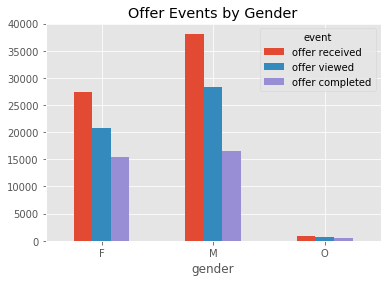

In [145]:
event_count_by_gender[['offer received', 'offer viewed', 'offer completed']].plot(kind='bar', rot=0,
                                                                                  title='Offer Events by Gender');
plt.savefig('event_by_gender.png')

In [146]:
transcript_new['gender'].value_counts(dropna=False)

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [147]:
event_count_by_agegroup = transcript_event_count_grouped(transcript_new, ['age_group', 'event'])
event_count_by_agegroup

event,offer completed,offer received,offer viewed,transaction,received_viewed_ratio,received_completed_ratio
age_group,,,,,,
"(17, 24]",1466,3938,2721,73472.38,0.690960,0.372270
"(24, 35]",2730,6798,4707,130250.47,0.692410,0.401589
"(35, 50]",7049,14780,11527,366954.29,0.779905,0.476928
"(50, 75]",17320,33603,25347,948607.03,0.754308,0.515430
"(75, 110]",3879,7382,5558,215658.23,0.752912,0.525467


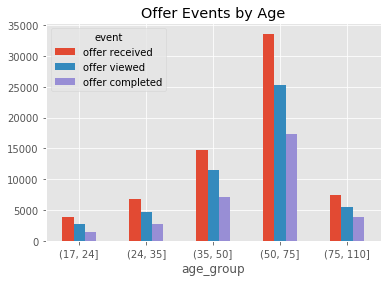

In [148]:
event_count_by_agegroup[['offer received', 'offer viewed', 'offer completed']].plot(kind='bar', rot=0,
                                                                                   title='Offer Events by Age');
plt.savefig('event_by_age.png')

In [149]:
transcript_new['age_group'].value_counts(dropna=False)

(50, 75]     134348
(35, 50]      61872
(24, 35]      29798
(75, 110]     29690
(17, 24]      17054
Name: age_group, dtype: int64

In [150]:
event_count_by_incomegroup = transcript_event_count_grouped(transcript_new, ['income_group', 'event'])
event_count_by_incomegroup

event,offer completed,offer received,offer viewed,transaction,received_viewed_ratio,received_completed_ratio
income_group,,,,,,
"(29910.0, 48000.0]",5781,16256,11114,240645.74,0.683686,0.355623
"(48000.0, 66000.0]",9369,20138,15714,448131.32,0.780316,0.465240
"(66000.0, 84000.0]",8967,16586,12819,498289.86,0.772881,0.540637
"(84000.0, 102000.0]",5763,9401,7496,376700.61,0.797362,0.613020
"(102000.0, 120000.0]",2564,4120,2717,171174.87,0.659466,0.622330


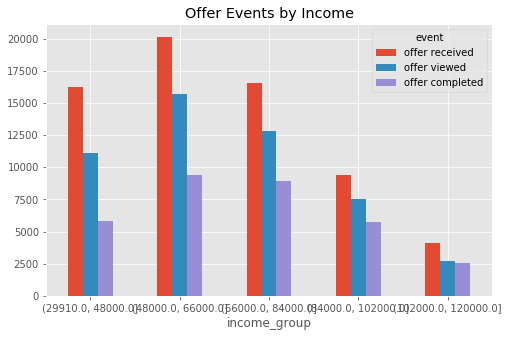

In [151]:
event_count_by_incomegroup[['offer received', 'offer viewed', 'offer completed']].plot(kind='bar', rot=0, figsize=(8,5),
                                                                                      title='Offer Events by Income');
plt.savefig('event_by_income.png')

In [152]:
transcript_new['income_group'].value_counts(dropna=False)

(48000.0, 66000.0]      85764
(29910.0, 48000.0]      69510
(66000.0, 84000.0]      66544
(84000.0, 102000.0]     36013
(102000.0, 120000.0]    14931
Name: income_group, dtype: int64

In [153]:
# Prepare data to be used in machine learning algorithms

transcript_new.head()

,customer_id,time,event,offer id,amount,amt_rewarded,difficulty,duration,offer_type,offer_reward,offer_email,offer_mobile,offer_social,offer_web,became_member_on,gender,age_group,income_group
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,2017-04-21,M,"(24, 35]","(66000.0, 84000.0]"
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,2017-04-21,M,"(24, 35]","(66000.0, 84000.0]"
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,0.0,0.0,X,0.0,0.0,0.0,0.0,0.0,2017-04-21,M,"(24, 35]","(66000.0, 84000.0]"
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,2017-04-21,M,"(24, 35]","(66000.0, 84000.0]"
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,2017-04-21,M,"(24, 35]","(66000.0, 84000.0]"


In [154]:
# offers_completed_by_cust = transcript_new[transcript_new['event'] == 'offer completed'].groupby(['customer_id', 'gender', 'age_group', 'income_group']).agg({'event': np.count_nonzero}).reset_index()

# offers_completed_by_cust.head()

In [155]:
# Check for NaN's

transcript_new.isnull().any()

customer_id         False
time                False
event               False
offer id             True
amount              False
amt_rewarded        False
difficulty          False
duration            False
offer_type          False
offer_reward        False
offer_email         False
offer_mobile        False
offer_social        False
offer_web           False
became_member_on    False
gender              False
age_group           False
income_group        False
dtype: bool

In [156]:
customer_offer_summary = transcript_new[transcript_new['event'] != 'transaction']
customer_transactions = transcript_new[transcript_new['event'] == 'transaction'][['customer_id', 'time', 'amount']]

In [157]:
# # For each customer, set the 'offer id' for each transaction as a cumulative number 

# transcript_new['offer id'] = transcript_new['offer id'].fillna(transcript_new['offer id'].isnull().cumsum())
# transcript_new.head()

In [158]:
# Rearange fields transcript_new table and separate each 'event' type into its own column with the value being the equal to
# the 'time' value.
# Then fill NaN values with 0

customer_offer_summary = customer_offer_summary.groupby(['customer_id', 'age_group', 'gender', 'became_member_on','income_group', 
                                                'offer id','offer_type', 'difficulty', 'duration', 'offer_email', 
                                                'offer_mobile', 'offer_social', 'offer_web', 'amount', 'event'])['time'].agg('first').unstack().reset_index()

In [159]:
customer_offer_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55222 entries, 0 to 55221
Data columns (total 17 columns):
customer_id         55222 non-null object
age_group           55222 non-null category
gender              55222 non-null object
became_member_on    55222 non-null datetime64[ns]
income_group        55222 non-null category
offer id            55222 non-null object
offer_type          55222 non-null object
difficulty          55222 non-null float64
duration            55222 non-null float64
offer_email         55222 non-null float64
offer_mobile        55222 non-null float64
offer_social        55222 non-null float64
offer_web           55222 non-null float64
amount              55222 non-null float64
offer completed     27942 non-null float64
offer received      55222 non-null float64
offer viewed        42493 non-null float64
dtypes: category(2), datetime64[ns](1), float64(10), object(4)
memory usage: 6.4+ MB


In [160]:
# Fill NaN values with 0

customer_offer_summary.fillna(pd.Series(0, index=customer_offer_summary.select_dtypes(exclude='category').columns), inplace=True)

In [161]:
# Create an 'offer expiration' field

customer_offer_summary['offer expiration'] = customer_offer_summary['offer received'] + customer_offer_summary['duration']
customer_offer_summary.head(10)

event,customer_id,age_group,gender,became_member_on,income_group,offer id,offer_type,difficulty,duration,offer_email,offer_mobile,offer_social,offer_web,amount,offer completed,offer received,offer viewed,offer expiration
0,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",2906b810c7d4411798c6938adc9daaa5,discount,10.0,168.0,1.0,1.0,0.0,1.0,0.0,576.0,576.0,0.0,744.0
1,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",3f207df678b143eea3cee63160fa8bed,informational,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,336.0,372.0,432.0
2,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",5a8bc65990b245e5a138643cd4eb9837,informational,0.0,72.0,1.0,1.0,1.0,0.0,0.0,0.0,168.0,192.0,240.0
3,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,120.0,1.0,1.0,1.0,1.0,0.0,414.0,408.0,456.0,528.0
4,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,240.0,1.0,1.0,1.0,1.0,0.0,528.0,504.0,540.0,744.0
5,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,240.0,1.0,0.0,0.0,1.0,0.0,576.0,408.0,432.0,648.0
6,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,168.0,1.0,1.0,1.0,1.0,0.0,252.0,168.0,186.0,336.0
7,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",3f207df678b143eea3cee63160fa8bed,informational,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,96.0
8,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",5a8bc65990b245e5a138643cd4eb9837,informational,0.0,72.0,1.0,1.0,1.0,0.0,0.0,0.0,336.0,354.0,408.0
9,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,168.0,1.0,1.0,0.0,1.0,0.0,576.0,504.0,516.0,672.0


In [162]:
customer_offer_summary.shape

(55222, 18)

In [163]:
customer_transactions.head(15)

,customer_id,time,amount
2,0009655768c64bdeb2e877511632db8f,228,22.16
6,0009655768c64bdeb2e877511632db8f,414,8.57
10,0009655768c64bdeb2e877511632db8f,528,14.11
13,0009655768c64bdeb2e877511632db8f,552,13.56
15,0009655768c64bdeb2e877511632db8f,576,10.27
17,0009655768c64bdeb2e877511632db8f,660,12.36
18,0009655768c64bdeb2e877511632db8f,690,28.16
19,0009655768c64bdeb2e877511632db8f,696,18.41
29,0011e0d4e6b944f998e987f904e8c1e5,132,13.49
32,0011e0d4e6b944f998e987f904e8c1e5,252,11.93


In [164]:
customer_transactions.shape

(123957, 3)

In [165]:
trans_amounts = []

for idx, row in enumerate(customer_offer_summary.iterrows()):
    trans_amount_list = []
    cust_id = customer_offer_summary.iloc[idx]['customer_id']
    cust_trans = customer_transactions[customer_transactions['customer_id'] == cust_id]
    
    for i, j in enumerate(cust_trans.iterrows()):
        trans_time = cust_trans.iloc[i]['time']
        trans_amount = cust_trans.iloc[i]['amount']
        if (trans_time >= customer_offer_summary.iloc[idx]['offer received']) & \
           (trans_time <= customer_offer_summary.iloc[idx]['offer completed']):
            trans_amount_list.append(trans_amount)
    trans_amounts.append(trans_amount_list)

In [166]:
with open('trans_amounts.pkl', 'wb') as f:
    pickle.dump(trans_amounts, f)
    
with open('trans_amounts.pkl', 'rb') as f:
    trans_amounts = pickle.load(f)

In [167]:
customer_offer_summary['trans amounts'] = trans_amounts

In [169]:
customer_offer_summary

event,customer_id,age_group,gender,became_member_on,income_group,offer id,offer_type,difficulty,duration,offer_email,offer_mobile,offer_social,offer_web,amount,offer completed,offer received,offer viewed,offer expiration,trans amounts
0,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",2906b810c7d4411798c6938adc9daaa5,discount,10.0,168.0,1.0,1.0,0.0,1.0,0.0,576.0,576.0,0.0,744.0,[10.27]
1,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",3f207df678b143eea3cee63160fa8bed,informational,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,336.0,372.0,432.0,[]
2,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",5a8bc65990b245e5a138643cd4eb9837,informational,0.0,72.0,1.0,1.0,1.0,0.0,0.0,0.0,168.0,192.0,240.0,[]
3,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,120.0,1.0,1.0,1.0,1.0,0.0,414.0,408.0,456.0,528.0,[8.57]
4,0009655768c64bdeb2e877511632db8f,"(24, 35]",M,2017-04-21,"(66000.0, 84000.0]",fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,240.0,1.0,1.0,1.0,1.0,0.0,528.0,504.0,540.0,744.0,[14.11]
5,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,240.0,1.0,0.0,0.0,1.0,0.0,576.0,408.0,432.0,648.0,[22.05]
6,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,168.0,1.0,1.0,1.0,1.0,0.0,252.0,168.0,186.0,336.0,[11.93]
7,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",3f207df678b143eea3cee63160fa8bed,informational,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,96.0,[]
8,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",5a8bc65990b245e5a138643cd4eb9837,informational,0.0,72.0,1.0,1.0,1.0,0.0,0.0,0.0,336.0,354.0,408.0,[]
9,0011e0d4e6b944f998e987f904e8c1e5,"(35, 50]",O,2018-01-09,"(48000.0, 66000.0]",9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,168.0,1.0,1.0,0.0,1.0,0.0,576.0,504.0,516.0,672.0,[22.05]


In [863]:
# get_dummies_list = ['age_group', 'gender', 'income_group', 'offer_type']

# for col in get_dummies_list:
#     customer_offer_summary = pd.concat([customer_offer_summary.drop(col, axis=1), pd.get_dummies(customer_offer_summary[col])], axis=1)

# customer_offer_summary.head(10)

## Questions

- How do customers react to the differnt 'offer_types'?
- Do Advertisment offer types spark an increase in purchases?